In [2]:
import tensorflow as tf
import json
import os

from core.data  import pretraining_records
from core.astromer import get_ASTROMER, train

import matplotlib.pyplot as plt
# from matplotlib import rc
# rc('text', usetex=True)

# plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

In [3]:
exp_path = './experiments/macho_3'

In [4]:
conf_file = os.path.join(exp_path, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)
conf

{'max_obs': 50,
 'data': './data/records/macho2/',
 'p': './experiments/macho_3',
 'batch_size': 256,
 'epochs': 4000,
 'patience': 3000,
 'finetuning': False,
 'repeat': 1,
 'layers': 2,
 'heads': 2,
 'head_dim': 106,
 'dff': 256,
 'dropout': 0.1,
 'base': 1000,
 'lr': 0.001}

In [5]:
test_batches = pretraining_records(os.path.join(conf['data'], 'test'), 
                            conf['batch_size'], 
                            max_obs=conf['max_obs'])

In [6]:
astromer = get_ASTROMER(num_layers=conf['layers'],
                        d_model=conf['head_dim'],
                        num_heads=conf['heads'],
                        dff=conf['dff'],
                        base=conf['base'],
                        dropout=conf['dropout'],
                        maxlen=conf['max_obs'])

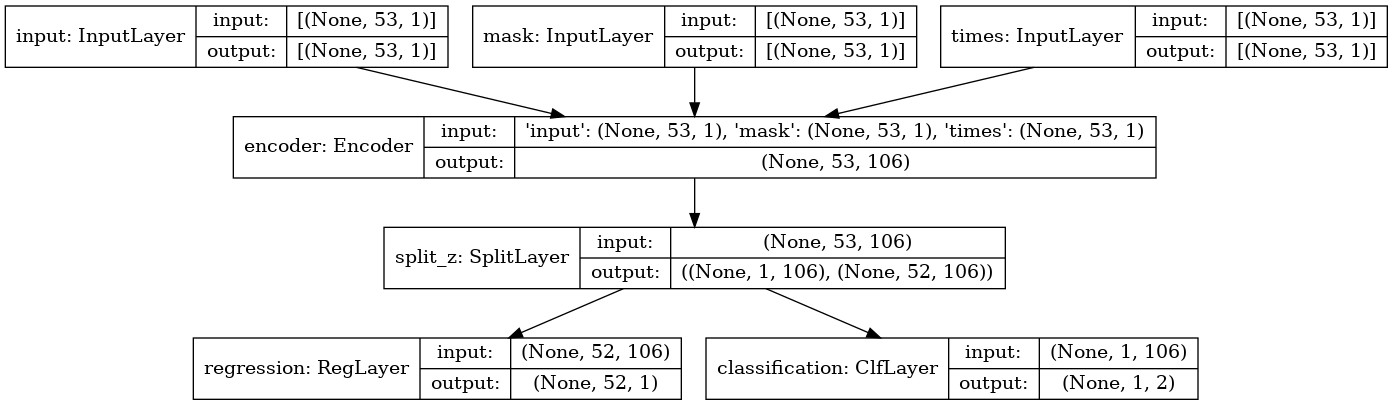

In [7]:
tf.keras.utils.plot_model(astromer, show_shapes=True)

In [50]:
pathexp = os.path.join(conf['p'], 'finetuning', 'model_0')
weights_path = '{}/weights'.format(pathexp)
astromer.load_weights(weights_path)

In [51]:
from core.astromer import predict

In [52]:
result = predict(astromer, test_batches, conf)
result['acc']

prediction: 367it [00:48,  7.62it/s]


0.83910483

In [53]:
result['mse']

0.17076537

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


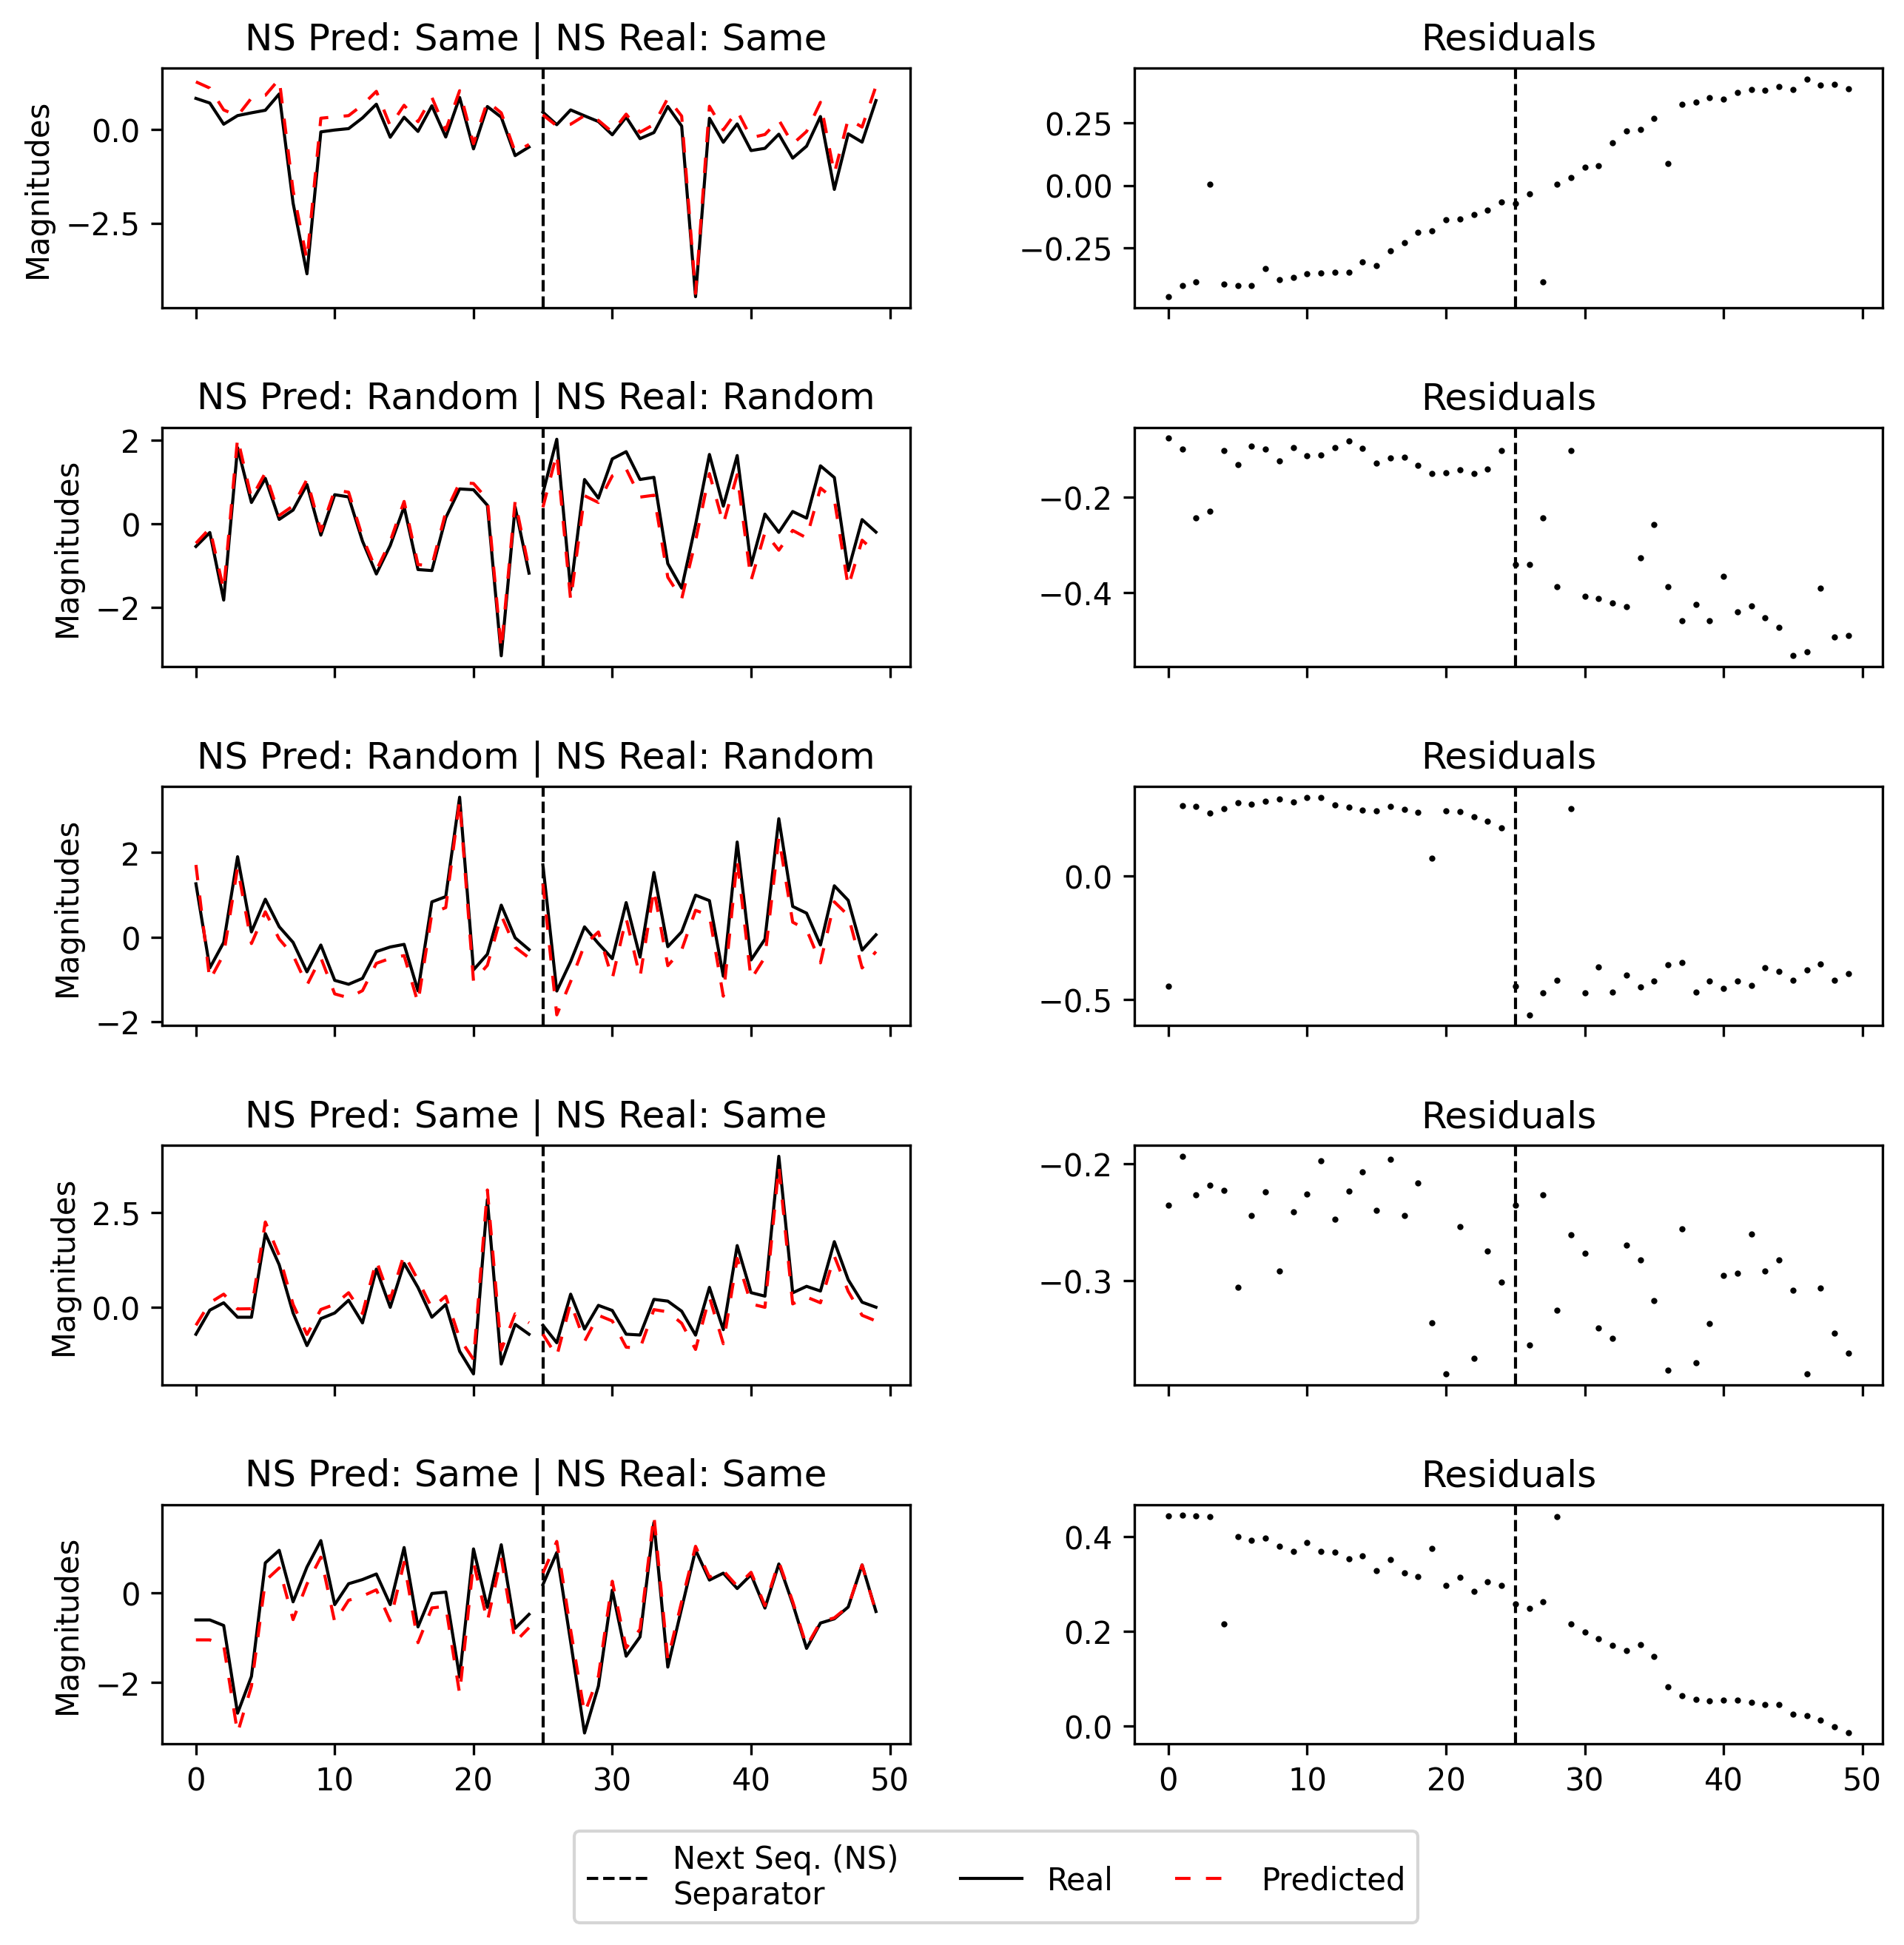

In [54]:
N = 5
fig, axes = plt.subplots(N, 2, dpi=300, figsize=(10,10),
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.3},
                         sharey=False, sharex=True)

obs = conf['max_obs']//2

for i in range(N):

    times_prev = range(0, obs)
    times_post = range(obs, conf['max_obs'])
    

    serie_1_pred = result['x_true'][i][1:obs+1]
    serie_1_true = result['x_pred'][i][:obs]

    residual_1 = serie_1_pred - serie_1_true

    serie_2_pred = result['x_true'][i][obs+2:-1]
    serie_2_true = result['x_pred'][i][obs+1:-1]

    residual_2 = serie_2_pred - serie_2_true
    
    axes[i][0].axvline(x=obs, color='k', linewidth=1, linestyle='--', label='Next Seq. (NS)\nSeparator')

    axes[i][0].plot(times_prev, serie_1_pred, marker='',linewidth=1, linestyle='-', color='k')
    axes[i][0].plot(times_prev, serie_1_true, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5))
    
    axes[i][0].plot(times_post, serie_2_true, marker='',linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(times_post, serie_2_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    

    axes[i][1].plot(times_prev, residual_1, '.', markersize=2, color='k')
    axes[i][1].plot(times_post, residual_2, '.', markersize=2, color='k')
    axes[i][1].axvline(x=obs, color='k', linewidth=1, linestyle='--')
    axes[i][1].set_title('Residuals')
    
    
    npp_lab_pred = 'Random' if result['y_pred'][i] == 1 else 'Same'
    npp_lab_true = 'Random' if result['y_true'][i] == 1 else 'Same'
    axes[i][0].set_title(r"NS Pred: "+npp_lab_pred+" | "+r"NS Real: "+npp_lab_true)

    axes[i][0].set_ylabel('Magnitudes')
    
axes[-1][0].legend(ncol=3, bbox_to_anchor = (1.7, -0.3))
fig.tight_layout()

## Learning Curves

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

In [46]:
pathexp = conf['p']
print(pathexp)
train_metrics = get_metrics(os.path.join(pathexp, 'logs', 'train'))
val_metrics = get_metrics(os.path.join(pathexp, 'logs', 'valid'))

./experiments/macho_3


Text(0.52, 0.08, 'Number of Epochs')

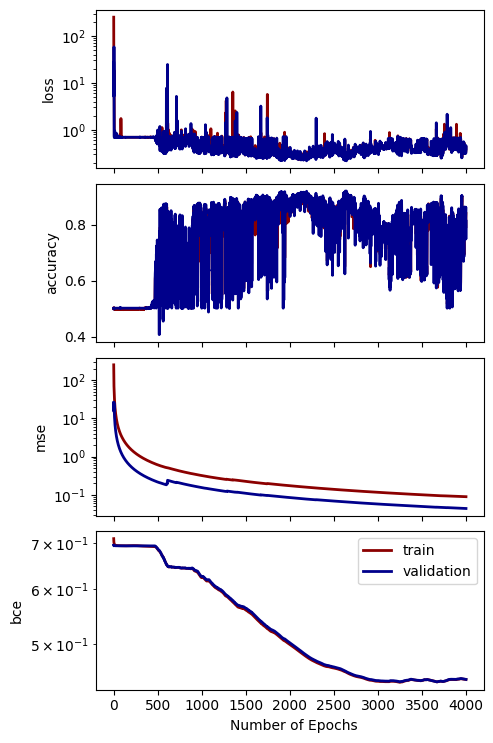

In [49]:
fig, axes = plt.subplots(4, 1, figsize=(5,9), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=100)
for i, key in enumerate(val_metrics.keys()):
    axes[i].plot(train_metrics[key], label='train', color='darkred', linewidth=2)
    axes[i].plot(val_metrics[key], label='validation', color='darkblue', linewidth=2)
    axes[i].set_ylabel(key)
    if key != 'accuracy':
        axes[i].set_yscale('log')
axes[-1].legend(loc='upper right')
fig.text(0.52, 0.08, 'Number of Epochs', ha='center')

## Finetuning

In [45]:
pathexp = os.path.join(conf['p'], 'finetuning', 'model_0')
print(pathexp)
train_metrics = get_metrics(os.path.join(pathexp, 'logs', 'train'))
val_metrics = get_metrics(os.path.join(pathexp, 'logs', 'valid'))

./experiments/macho_3/finetuning/model_0


Text(0.52, 0.07, 'Number of Epochs')

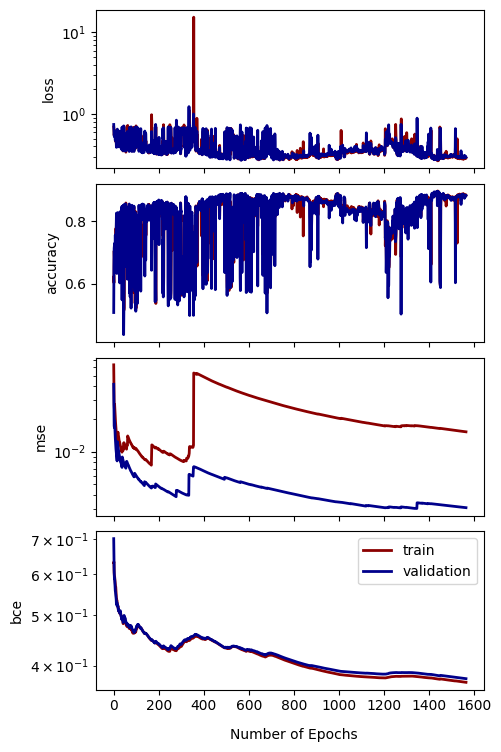

In [44]:
fig, axes = plt.subplots(4, 1, figsize=(5,9), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=100)
for i, key in enumerate(val_metrics.keys()):
    axes[i].plot(train_metrics[key], label='train', color='darkred', linewidth=2)
    axes[i].plot(val_metrics[key], label='validation', color='darkblue', linewidth=2)
    axes[i].set_ylabel(key)
    if key != 'accuracy':
        axes[i].set_yscale('log')
axes[-1].legend(loc='upper right')
fig.text(0.52, 0.07, 'Number of Epochs', ha='center')

## Special Task: Classification